In [1]:
import matplotlib.pyplot as plt
import numpy as np

import gpflow
import pandas as pd
import os
import matplotlib.pyplot as plt
import re
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm


2024-04-15 17:29:04.524609: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-15 17:29:04.786246: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /share/apps/22.04/openmpi/4.1.5/lib:/share/apps/22.04/slurm/23.02.7/lib
2024-04-15 17:29:04.786311: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-04-15 17:29:04.832531: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has al

In [3]:
def plot_2d_model(model: gpflow.models.GPModel) -> None:
    n_grid = 50
    _, (ax_mean, ax_std) = plt.subplots(nrows=1, ncols=2, figsize=(11, 5))
    Xplots = np.linspace(0.0, 1.0, n_grid)
    Xplot1, Xplot2 = np.meshgrid(Xplots, Xplots)
    Xplot = np.stack([Xplot1, Xplot2], axis=-1)
    Xplot = Xplot.reshape([n_grid ** 2, 2])

    iv = getattr(model, "inducing_variable", None)
    # Do not optimize inducing variables, so that we can better see the impact their choice has. When solving
    # a real problem you should generally optimise your inducing points.
    if iv is not None:
        gpflow.set_trainable(iv, False)
    opt = gpflow.optimizers.Scipy()
    opt.minimize(model.training_loss, model.trainable_variables)

    y_mean, y_var = model.predict_y(Xplot)
    y_mean = y_mean.numpy()
    y_std = tf.sqrt(y_var).numpy()

    ax_mean.pcolor(Xplot1, Xplot2, y_mean.reshape(Xplot1.shape))
    ax_std.pcolor(Xplot1, Xplot2, y_std.reshape(Xplot1.shape))
    ax_mean.scatter(X[:, 0], X[:, 1], s=50, c="black")
    ax_std.scatter(X[:, 0], X[:, 1], s=50, c="black")

    # Also plot the inducing variables if possible:
    if iv is not None:
        ax_mean.scatter(iv.Z[:, 0], iv.Z[:, 1], marker="x", color="red")

In [2]:
model_data = pd.read_csv('/home/smmrrr/TEM_Analysis/TEM_Analysis/region_3_test_model_data_conif_vegc.csv')
unique_bins = sorted(model_data.stand_age_interval_min.unique())
bin_to_ordinal = {bin_val: idx for idx, bin_val in (enumerate(unique_bins))}
print(bin_to_ordinal)
model_data['ordinal_stand_age'] = model_data['stand_age_interval_min'].map(bin_to_ordinal)
model_data['ordinal_stand_age'].describe()
# model_data = model_data.loc[model_data['year']>=1900]

{0: 0, 5: 1, 10: 2, 15: 3, 20: 4, 25: 5, 30: 6, 35: 7, 40: 8, 45: 9, 50: 10, 55: 11, 60: 12, 65: 13, 70: 14, 75: 15, 80: 16, 85: 17, 90: 18, 95: 19, 100: 20, 125: 21, 150: 22}


count    287630.000000
mean          9.834551
std           7.873397
min           0.000000
25%           3.000000
50%           8.000000
75%          17.000000
max          22.000000
Name: ordinal_stand_age, dtype: float64

In [3]:
variables_to_compare = ['monthly_mean', 'tswrf_v11', 'tmp', 'precip', 'dtr', 'vpr', 'wind','co2','Ndep_Trendy']

base_comparison = model_data.loc[model_data['year'].between(1900,1950)].groupby(
    ['lon','lat','ordinal_stand_age'])[variables_to_compare].mean().reset_index()


model_data=model_data.merge(base_comparison, on = ['lon','lat','ordinal_stand_age'], suffixes = ('_ts', '_base'))

# Iterate over the list of variables and create new columns in model_data for their ratios
for var in variables_to_compare:
    ts_column = f"{var}_ts"     # Time series data column name
    base_column = f"{var}_base" # Baseline data column name
    ratio_column = f"{var}_ratio" # Name for the new ratio column

    # Compute the ratio and create a new column in model_data
    model_data[ratio_column] = model_data[ts_column] / model_data[base_column]



In [28]:
model_data['tmp_exp_ratio'] = np.exp(model_data['tmp_ts'])/np.exp(model_data['tmp_base'])

In [27]:
model_data['tmp_ratio']

200       0.990101
201       0.956772
202       1.001381
203       0.952671
204       0.998304
            ...   
193625    1.003096
193626    1.105263
193627    1.202786
193783    1.018239
193784    1.132435
Name: tmp_ratio, Length: 122116, dtype: float64

In [24]:
model_data['tmp_ts'].dtypes

dtype('float64')

In [63]:
# model_data.loc[model_data['monthly_mean']>=30000]
model_data.columns



Index(['lon', 'lat', 'year', 'stand_age_interval_min', 'silt_clay',
       'monthly_mean_ts', 'tswrf_v11_ts', 'tmp_ts', 'precip_ts', 'dtr_ts',
       'vpr_ts', 'wind_ts', 'Ndep_Trendy_ts', 'Nfer_crop', 'Nfer_pas', 'var',
       'Area', 'elev', 'region', 'co2_ts', 'ordinal_stand_age',
       'monthly_mean_base', 'tswrf_v11_base', 'tmp_base', 'precip_base',
       'dtr_base', 'vpr_base', 'wind_base', 'co2_base', 'Ndep_Trendy_base',
       'monthly_mean_ratio', 'tswrf_v11_ratio', 'tmp_ratio', 'precip_ratio',
       'dtr_ratio', 'vpr_ratio', 'wind_ratio', 'co2_ratio',
       'Ndep_Trendy_ratio'],
      dtype='object')

In [4]:
model_data = model_data.loc[model_data['year']>=1950]

In [7]:
len(model_data.loc[model_data['monthly_mean_ratio']>3])/len(model_data)

0.056462845602061426

In [8]:
model_data = model_data.loc[model_data['monthly_mean_ratio']<=3]

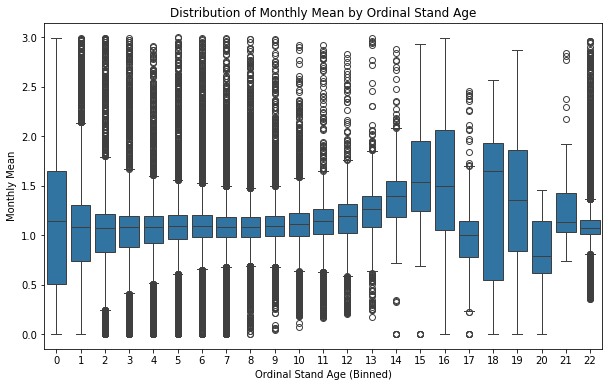

In [9]:
# Plotting a boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='ordinal_stand_age', y='monthly_mean_ratio', data=model_data)
plt.title('Distribution of Monthly Mean by Ordinal Stand Age')
plt.xlabel('Ordinal Stand Age (Binned)')
plt.ylabel('Monthly Mean')
plt.show()

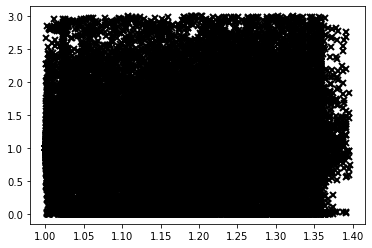

In [10]:
Y = np.array(
    model_data.monthly_mean_ratio
)
X = np.array(
    model_data.co2_ratio
)

plt.plot(X, Y, "kx", mew=2)

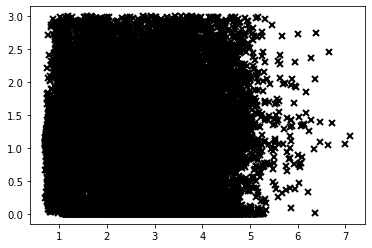

In [11]:
Y = np.array(
    model_data.monthly_mean_ratio
)
X = np.array(
    model_data.Ndep_Trendy_ratio
)

plt.plot(X, Y, "kx", mew=2)

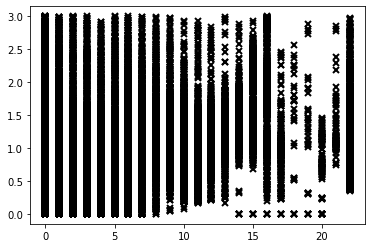

In [12]:
Y = np.array(
    model_data.monthly_mean_ratio
)
X = np.array(
    model_data.ordinal_stand_age
)

plt.plot(X, Y, "kx", mew=2)

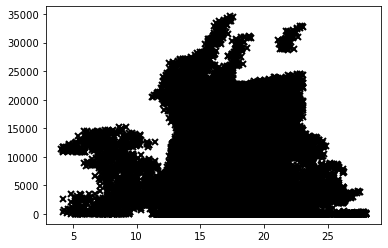

In [13]:
Y = np.array(
    model_data.monthly_mean_ts
)
X = np.array(
    model_data.tmp_ts
)

plt.plot(X, Y, "kx", mew=2)

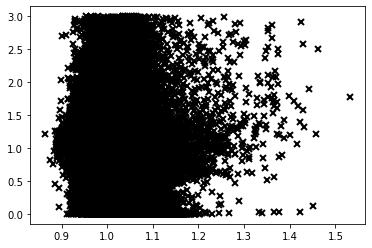

In [14]:
Y = np.array(
    model_data.monthly_mean_ratio
)
X = np.array(
    model_data.tmp_ratio
)

plt.plot(X, Y, "kx", mew=2)

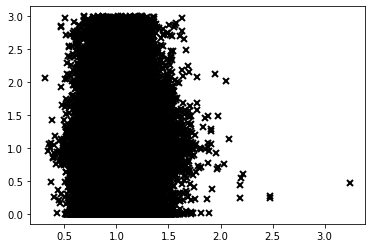

In [15]:
Y = np.array(
    model_data.monthly_mean_ratio
)
X = np.array(
    model_data.precip_ratio
)

plt.plot(X, Y, "kx", mew=2)

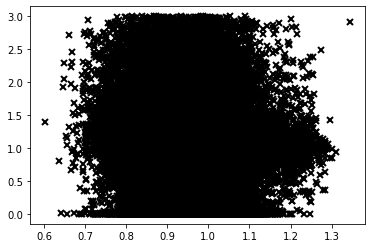

In [16]:
Y = np.array(
    model_data.monthly_mean_ratio
)
X = np.array(
    model_data.dtr_ratio
)

plt.plot(X, Y, "kx", mew=2)

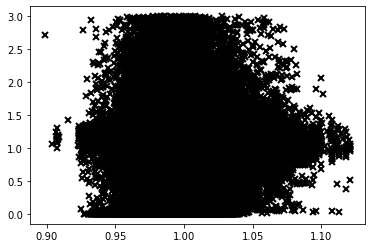

In [17]:
Y = np.array(
    model_data.monthly_mean_ratio
)
X = np.array(
    model_data.tswrf_v11_ratio
)

plt.plot(X, Y, "kx", mew=2)

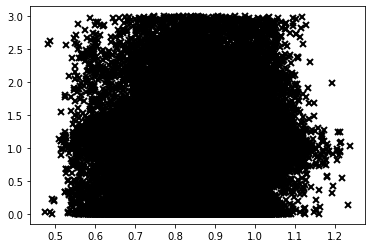

In [18]:
Y = np.array(
    model_data.monthly_mean_ratio
)
X = np.array(
    model_data.wind_ratio
)

plt.plot(X, Y, "kx", mew=2)

In [10]:
model_data.columns

Index(['lon', 'lat', 'year', 'stand_age_interval_min', 'silt_clay',
       'monthly_mean_ts', 'tswrf_v11_ts', 'tmp_ts', 'precip_ts', 'dtr_ts',
       'vpr_ts', 'wind_ts', 'Ndep_Trendy_ts', 'Nfer_crop', 'Nfer_pas', 'var',
       'Area', 'elev', 'region', 'co2_ts', 'ordinal_stand_age',
       'monthly_mean_base', 'tswrf_v11_base', 'tmp_base', 'precip_base',
       'dtr_base', 'vpr_base', 'wind_base', 'co2_base', 'Ndep_Trendy_base',
       'monthly_mean_ratio', 'tswrf_v11_ratio', 'tmp_ratio', 'precip_ratio',
       'dtr_ratio', 'vpr_ratio', 'wind_ratio', 'co2_ratio',
       'Ndep_Trendy_ratio'],
      dtype='object')

In [19]:
# # Fit the model
# model = sm.OLS(m_test1['change_variable'], m_test1[[ 'stand_age_interval_min']])


model = sm.OLS(model_data['monthly_mean_ratio'], model_data[[ 'stand_age_interval_min', 'silt_clay','tswrf_v11_ratio', 'tmp_ratio', 'precip_ratio',
       'dtr_ratio', 'vpr_ratio', 'wind_ratio', 'co2_ratio',
       'Ndep_Trendy_ratio']])

results = model.fit()

##Print the regression results
print(results.summary())


                                 OLS Regression Results                                
Dep. Variable:     monthly_mean_ratio   R-squared (uncentered):                   0.879
Model:                            OLS   Adj. R-squared (uncentered):              0.879
Method:                 Least Squares   F-statistic:                          7.708e+04
Date:                Mon, 15 Apr 2024   Prob (F-statistic):                        0.00
Time:                        17:33:04   Log-Likelihood:                         -55452.
No. Observations:              106606   AIC:                                  1.109e+05
Df Residuals:                  106596   BIC:                                  1.110e+05
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------

(array([ 2139.,  1509.,   660.,   423.,   484.,   311.,   407.,   391.,
          478.,   453.,   520.,   681.,   912.,  1263.,  1920.,  3346.,
         9218., 24432., 25536., 15395.,  6124.,  2980.,  1844.,  1266.,
          956.,   859.,   707.,   561.,   412.,   419.]),
 array([0.        , 0.05773376, 0.11546752, 0.17320128, 0.23093504,
        0.2886688 , 0.34640256, 0.40413632, 0.46187009, 0.51960385,
        0.57733761, 0.63507137, 0.69280513, 0.75053889, 0.80827265,
        0.86600641, 0.92374017, 0.98147393, 1.03920769, 1.09694145,
        1.15467521, 1.21240897, 1.27014274, 1.3278765 , 1.38561026,
        1.44334402, 1.50107778, 1.55881154, 1.6165453 , 1.67427906,
        1.73201282]),
 <BarContainer object of 30 artists>)

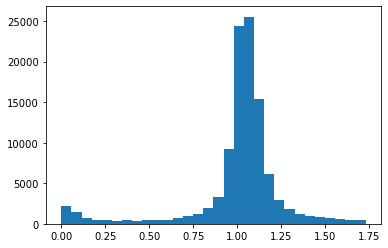

In [20]:
plt.hist(np.sqrt(model_data['monthly_mean_ratio']),bins=30)

In [40]:
np.log(model_data['monthly_mean_ratio'])

200       0.019932
201       0.018680
202       0.013299
203       0.016407
204       0.026617
            ...   
193625    0.346529
193626    0.719522
193627    1.424537
193783   -0.018739
193784   -0.017479
Name: monthly_mean_ratio, Length: 122116, dtype: float64

In [41]:
model_data['monthly_mean_ratio'].describe()

count    122116.000000
mean          1.433895
std           1.169208
min           0.000000
25%           1.016156
50%           1.161437
75%           1.470315
max           9.997253
Name: monthly_mean_ratio, dtype: float64

In [21]:


model = sm.OLS(np.sqrt(model_data['monthly_mean_ratio']), model_data[[ 'tmp_ratio','co2_ratio','ordinal_stand_age']])

results = model.fit()

##Print the regression results
print(results.summary())


                                 OLS Regression Results                                
Dep. Variable:     monthly_mean_ratio   R-squared (uncentered):                   0.935
Model:                            OLS   Adj. R-squared (uncentered):              0.935
Method:                 Least Squares   F-statistic:                          5.139e+05
Date:                Mon, 15 Apr 2024   Prob (F-statistic):                        0.00
Time:                        17:33:21   Log-Likelihood:                         -9783.3
No. Observations:              106606   AIC:                                  1.957e+04
Df Residuals:                  106603   BIC:                                  1.960e+04
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

In [22]:
# Define the features and target variable
X = model_data[['tmp_ratio', 'co2_ratio', 'ordinal_stand_age']]
Y = (model_data['monthly_mean_ratio'])
# Y = np.sqrt(model_data['monthly_mean_ratio'])

# Split the data into training and testing sets (80% train, 20% test)
# randomness can be controlled with a defined `random_state`
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# # Add a constant to the predictor variable set to include an intercept in the model
# X_train = sm.add_constant(X_train)
# X_test = sm.add_constant(X_test)

# Fit the OLS model using statsmodels on the training data
model = sm.OLS(Y_train, X_train)
results = model.fit()

# Print the regression results
print(results.summary())

# Make predictions on the testing data
Y_pred = results.predict(X_test)

# Calculate RMSE and R² for the predictions
rmse = np.sqrt(mean_squared_error(Y_test, Y_pred))
r2 = r2_score(Y_test, Y_pred)

print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")

                                 OLS Regression Results                                
Dep. Variable:     monthly_mean_ratio   R-squared (uncentered):                   0.874
Model:                            OLS   Adj. R-squared (uncentered):              0.874
Method:                 Least Squares   F-statistic:                          1.964e+05
Date:                Mon, 15 Apr 2024   Prob (F-statistic):                        0.00
Time:                        17:33:43   Log-Likelihood:                         -46092.
No. Observations:               85284   AIC:                                  9.219e+04
Df Residuals:                   85281   BIC:                                  9.222e+04
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

In [23]:
Y = np.array(
    model_data.monthly_mean
)
X = np.array(
    model_data.precip
)

plt.plot(X, Y, "kx", mew=2)

AttributeError: 'DataFrame' object has no attribute 'monthly_mean'

In [26]:
Y = np.array(
    # model_data.loc[model_data['year']>=2021, 'monthly_mean_ratio']
    model_data['monthly_mean_ratio']
)
X = np.array(
     # model_data.loc[model_data['year']>=2020,['ordinal_stand_age']]
     model_data[['ordinal_stand_age','tmp_ratio']]
)
Y=Y.reshape(len(Y),1)

In [89]:
print('y: ',len(Y),' x: ',len(X) )

y:  983  x:  983


In [31]:
X

array([[ 0.        ,  1.0572591 ],
       [ 0.        ,  1.0336733 ],
       [ 1.        ,  1.05742267],
       ...,
       [22.        ,  1.34877878],
       [ 0.        ,  1.35281711],
       [ 0.        ,  1.32118108]])

In [24]:
model = gpflow.models.GPR(
    (X, Y),
    kernel=gpflow.kernels.SquaredExponential(),
)
# plot_2d_model(model)

2024-04-15 17:34:13.756170: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-04-15 17:34:13.756281: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (bm8): /proc/driver/nvidia/version does not exist
2024-04-15 17:34:13.760307: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


ShapeMismatchError: 
Tensor shape mismatch.
  Function: GPR_deprecated.__init__
    Declared: /home/smmrrr/miniconda3/envs/condaforge/lib/python3.10/site-packages/gpflow/models/gpr.py:59
    Argument: data
      Index: [0]
        Expected: [N, D]
        Actual:   [106606, 3]
      Index: [1]
        Expected: [N, P]
        Actual:   [106606]
    Argument: noise_variance
      Expected: []
      Actual:   <Tensor is None or has unknown shape>


In [30]:
gpflow.utilities.print_summary(model, "notebook")

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,1
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,1
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1


In [86]:
model = gpflow.models.GPR(
    (X, Y),
    kernel=gpflow.kernels.RBF()
)

In [59]:
iter(model_data)

In [ ]:
import tensorflow as tf

start_time = time.time()
# Instantiate an Adam optimizer with a set learning rate
adam_optimizer = tf.optimizers.Adam(learning_rate=0.01)

# Run the optimization loop
# Perform a number of optimization steps
num_iterations = 1000  # Choose an appropriate number of iterations for your problem
for i in range(num_iterations):
    adam_optimizer.minimize(model.training_loss, model.trainable_variables)
    if (i % 100 ==0):
        print(i)
        elapsed_time_minutes = (time.time() - start_time) / 60
        print(f"Elapsed time: {elapsed_time_minutes:.2f} minutes")

In [62]:
gpflow.utilities.print_summary(model, "notebook")

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,13.3541
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.0608721
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.490557


In [63]:
mean, var = model.predict_y(np.array(
     model_data.loc[model_data['year'].between(1950,2020),['ordinal_stand_age','tmp_ratio']]
))

Y_pred = mean.numpy().flatten()
Y_true = np.array(model_data.loc[model_data['year'].between(1950,2020),'monthly_mean_ratio'])

# Calculate the sum of squares of residuals
SS_res = np.sum((Y_true - Y_pred) ** 2)

# Calculate the total sum of squares
SS_tot = np.sum((Y_true - np.mean(Y_true)) ** 2)

# Calculate the R² score
r2_score = 1 - (SS_res / SS_tot)

print(r2_score)



0.3374905215889874


In [77]:
Y = np.array(
    model_data.loc[:, 'monthly_mean_ratio']
)
X = np.array(
     # model_data.loc[model_data['year']>=2020,['ordinal_stand_age']]
     model_data.loc[:,['ordinal_stand_age','tmp_ratio']]
)
Y = Y.reshape(len(Y),1)

In [27]:
rng = np.random.default_rng(1234)
n_inducing = 500
inducing_variable = rng.choice(X, size=n_inducing, replace=False)


In [28]:
inducing_variable

array([[ 0.        ,  0.97369562],
       [10.        ,  1.03037599],
       [ 6.        ,  1.00344328],
       [ 4.        ,  0.98116537],
       [ 6.        ,  0.99468177],
       [ 5.        ,  1.0109182 ],
       [ 6.        ,  1.03422422],
       [ 7.        ,  0.99577295],
       [22.        ,  1.06186888],
       [ 5.        ,  0.99334359],
       [ 9.        ,  0.95846512],
       [ 3.        ,  1.03378378],
       [ 7.        ,  0.97867095],
       [ 9.        ,  1.03946602],
       [ 5.        ,  0.99502138],
       [ 2.        ,  0.99029126],
       [ 4.        ,  0.97055919],
       [ 3.        ,  0.99606956],
       [ 7.        ,  1.03492243],
       [22.        ,  1.00432253],
       [ 2.        ,  1.06561756],
       [12.        ,  0.99854079],
       [ 0.        ,  1.01905594],
       [ 0.        ,  1.05589369],
       [13.        ,  0.98222426],
       [ 8.        ,  0.99277151],
       [13.        ,  1.02687869],
       [ 1.        ,  0.99072848],
       [ 4.        ,

In [29]:
# model = gpflow.models.GPR(
#     (X, Y),
#     kernel=gpflow.kernels.SquaredExponential(),
# )
model = gpflow.models.SGPR(
    (X, Y),
    kernel=gpflow.kernels.RBF(),
    # kernel=gpflow.kernels.SquaredExponential(),
    inducing_variable=inducing_variable,
        # noise_variance=1.0  # Set to some reasonable initial value
)


In [30]:
gpflow.utilities.print_summary(model, "notebook")

name,class,transform,prior,trainable,shape,dtype,value
SGPR.kernel.variance,Parameter,Softplus,,True,(),float64,1.0
SGPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,1.0
SGPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0
SGPR.inducing_variable.Z,Parameter,Identity,,True,"(500, 2)",float64,"[[0., 0.97369562..."


In [31]:
import tensorflow as tf

start_time = time.time()
# Instantiate an Adam optimizer with a set learning rate
adam_optimizer = tf.optimizers.Adam(learning_rate=0.01)

# Run the optimization loop
# Perform a number of optimization steps
num_iterations = 10000  # Choose an appropriate number of iterations for your problem
for i in range(num_iterations):
    adam_optimizer.minimize(model.training_loss, model.trainable_variables)
    if (i % 1000 ==0):
        print(i)
        elapsed_time_minutes = (time.time() - start_time) / 60
        print(f"Elapsed time: {elapsed_time_minutes:.2f} minutes")

0
Elapsed time: 0.36 minutes


KeyboardInterrupt: 

In [32]:
print(i)
gpflow.utilities.print_summary(model, "notebook")

53


name,class,transform,prior,trainable,shape,dtype,value
SGPR.kernel.variance,Parameter,Softplus,,True,(),float64,0.8887179759111207
SGPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,1.25774
SGPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.69720960379105
SGPR.inducing_variable.Z,Parameter,Identity,,True,"(500, 2)",float64,"[[1.07811088e-01, 7.33653399e-01..."


In [33]:
mean, var = model.predict_y(np.array(
     model_data.loc[model_data['year'].between(1950,2020),['ordinal_stand_age','tmp_ratio']]
))

Y_pred = mean.numpy().flatten()
Y_true = np.array(model_data.loc[model_data['year'].between(1950,2020),'monthly_mean_ratio'])

# Calculate the sum of squares of residuals
SS_res = np.sum((Y_true - Y_pred) ** 2)

# Calculate the total sum of squares
SS_tot = np.sum((Y_true - np.mean(Y_true)) ** 2)

# Calculate the R² score
r2_score = 1 - (SS_res / SS_tot)

print(r2_score)



0.08476093775570293


In [ ]:
opt = gpflow.optimizers.Scipy()
opt.minimize(model.training_loss, model.trainable_variables)

2024-04-05 18:08:48.952282: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.


In [5]:
Xnew = np.array([[0.5]])
model.predict_f(Xnew)

(<tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[4.28009566]])>,
 <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.30584767]])>)

In [6]:
model.predict_y(Xnew)

(<tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[4.28009566]])>,
 <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.54585965]])>)

In [8]:
Xplot = np.linspace(-0.1, 1.1, 100)[:, None]

f_mean, f_var = model.predict_f(Xplot, full_cov=False)
y_mean, y_var = model.predict_y(Xplot)

In [9]:
f_lower = f_mean - 1.96 * np.sqrt(f_var)
f_upper = f_mean + 1.96 * np.sqrt(f_var)
y_lower = y_mean - 1.96 * np.sqrt(y_var)
y_upper = y_mean + 1.96 * np.sqrt(y_var)

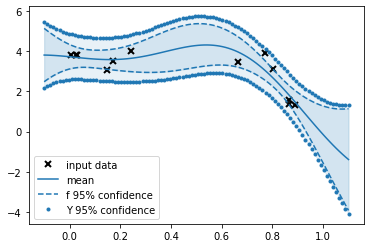

In [10]:
plt.plot(X, Y, "kx", mew=2, label="input data")
plt.plot(Xplot, f_mean, "-", color="C0", label="mean")
plt.plot(Xplot, f_lower, "--", color="C0", label="f 95% confidence")
plt.plot(Xplot, f_upper, "--", color="C0")
plt.fill_between(
    Xplot[:, 0], f_lower[:, 0], f_upper[:, 0], color="C0", alpha=0.1
)
plt.plot(Xplot, y_lower, ".", color="C0", label="Y 95% confidence")
plt.plot(Xplot, y_upper, ".", color="C0")
plt.fill_between(
    Xplot[:, 0], y_lower[:, 0], y_upper[:, 0], color="C0", alpha=0.1
)
plt.legend()